In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from sklearn.utils import class_weight

# ============ CONFIGURACIÓN ============
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_DIR = "flores"

# ============ DATA AUGMENTATION (aplicado al dataset) ============
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomBrightness(0.2),
])

def augment(image, label):
    return data_augmentation(image, training=True), label

# ============ CARGAR DATOS ============
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/train',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/val',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR + '/test',
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

# ============ CALCULAR PESOS DE CLASE ============
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())
train_labels = np.array(train_labels)

class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

# ============ APLICAR AUGMENTATION Y OPTIMIZACIÓN ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ============ MODELO (SIN data augmentation integrado) ============
def build_model(input_shape=(224,224,3), num_classes=5):
    inputs = layers.Input(shape=input_shape)
    
    # Normalización
    x = layers.Rescaling(1./127.5, offset=-1)(inputs)
    
    # Modelo preentrenado
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model, base_model

# Crear modelo
model, base_model = build_model(input_shape=(224,224,3), num_classes=num_classes)

# ============ COMPILAR ============
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# ============ ENTRENAR FASE 1 ============
print("\n=== ENTRENANDO FASE 1 (Transfer Learning) ===")

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weights
)

# ============ FINE-TUNING FASE 2 ============
print("\n=== ENTRENANDO FASE 2 (Fine-Tuning) ===")
base_model.trainable = True

# Congelar las primeras capas
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Capas entrenables: {sum([1 for layer in base_model.layers if layer.trainable])}")

# Recompilar con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint2 = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint2, early_stop2, reduce_lr2],
    class_weight=class_weights
)

# ============ GUARDAR MODELO ============
model.save("flower_model_final.h5")
print("\n✓ Modelo guardado: flower_model_final.h5")

Found 3017 files belonging to 5 classes.
Found 865 files belonging to 5 classes.
Found 435 files belonging to 5 classes.
Clases: ['diente_de_leon', 'girasol', 'margarita', 'rosa', 'tulipan']

=== ENTRENANDO FASE 1 (Transfer Learning) ===
Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5230 - loss: 1.4134
Epoch 1: val_accuracy improved from None to 0.85202, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 122s 607ms/step - accuracy: 0.5979 - loss: 1.1482 - val_accuracy: 0.8520 - val_loss: 0.4425 - learning_rate: 0.0010
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7420 - loss: 0.7001
Epoch 2: val_accuracy improved from 0.85202 to 0.85318, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 532ms/step - accuracy: 0.7315 - loss: 0.7142 - val_accuracy: 0.8532 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7941 - loss: 0.5654
Epoch 3: val_accuracy did not improve from 0.85318
189/189 ━━━━━━━━━━━━━━━━━━━━ 110s 582ms/step - accuracy: 0.7882 - loss: 0.5711 - val_accuracy: 0.8486 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8036 - loss: 0.5193
Epoch 4: val_accuracy improved from 0.85318 to 0.86243, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 103s 546ms/step - accuracy: 0.7955 - loss: 0.5501 - val_accuracy: 0.8624 - val_loss: 0.3598 - learning_rate: 0.0010
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8195 - loss: 0.4850
Epoch 5: val_accuracy improved from 0.86243 to 0.86936, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 123s 650ms/step - accuracy: 0.8111 - loss: 0.5004 - val_accuracy: 0.8694 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8323 - loss: 0.4347
Epoch 6: val_accuracy did not improve from 0.86936
189/189 ━━━━━━━━━━━━━━━━━━━━ 102s 540ms/step - accuracy: 0.8316 - loss: 0.4317 - val_accuracy: 0.8682 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8543 - loss: 0.3943
Epoch 7: val_accuracy did not improve from 0.86936
189/189 ━━━━━━━━━━━━━━━━━━━━ 140s 530ms/step - accuracy: 0.8492 - loss: 0.4037 - val_accuracy: 0.8613 - val_loss: 0.3475 - learning_rate: 0.0010
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8597 - loss: 0.3639
Epoch 8: val_accuracy improved from 0.86936 to 0.87052, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 94s 497ms/step - accuracy: 0.8571 - loss: 0.3796 - val_accuracy: 0.8705 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8589 - loss: 0.3443
Epoch 9: val_accuracy improved from 0.87052 to 0.87399, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 94s 496ms/step - accuracy: 0.8558 - loss: 0.3523 - val_accuracy: 0.8740 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8795 - loss: 0.3103
Epoch 10: val_accuracy improved from 0.87399 to 0.87630, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 524ms/step - accuracy: 0.8717 - loss: 0.3273 - val_accuracy: 0.8763 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8727 - loss: 0.3371
Epoch 11: val_accuracy did not improve from 0.87630
189/189 ━━━━━━━━━━━━━━━━━━━━ 93s 493ms/step - accuracy: 0.8677 - loss: 0.3432 - val_accuracy: 0.8613 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 12/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8815 - loss: 0.3181
Epoch 12: val_accuracy improved from 0.87630 to 0.87746, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 93s 494ms/step - accuracy: 0.8803 - loss: 0.3116 - val_accuracy: 0.8775 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 13/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8976 - loss: 0.2616
Epoch 13: val_accuracy did not improve from 0.87746
189/189 ━━━━━━━━━━━━━━━━━━━━ 120s 637ms/step - accuracy: 0.8886 - loss: 0.2953 - val_accuracy: 0.8751 - val_loss: 0.3396 - learning_rate: 0.0010
Epoch 14/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8992 - loss: 0.2598
Epoch 14: val_accuracy did not improve from 0.87746
189/189 ━━━━━━━━━━━━━━━━━━━━ 101s 535ms/step - accuracy: 0.8989 - loss: 0.2666 - val_accuracy: 0.8624 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 15/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9018 - loss: 0.2768
Epoch 15: val_accuracy did not improve from 0.87746
189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 531ms/step - accuracy: 0.8972 - loss: 0.2745 - val_accuracy: 0.8705 - val_loss: 0.3613 - learning_rate: 0.001


Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
189/189 ━━━━━━━━━━━━━━━━━━━━ 95s 502ms/step - accuracy: 0.9065 - loss: 0.2545 - val_accuracy: 0.8821 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 18/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9127 - loss: 0.2356
Epoch 18: val_accuracy did not improve from 0.88208
189/189 ━━━━━━━━━━━━━━━━━━━━ 93s 495ms/step - accuracy: 0.9214 - loss: 0.2148 - val_accuracy: 0.8717 - val_loss: 0.3647 - learning_rate: 3.0000e-04
Epoch 19/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9297 - loss: 0.1929
Epoch 19: val_accuracy did not improve from 0.88208
189/189 ━━━━━━━━━━━━━━━━━━━━ 110s 583ms/step - accuracy: 0.9277 - loss: 0.1970 - val_accuracy: 0.8694 - val_loss: 0.3717 - learning_rate: 3.0000e-04
Epoch 20/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9314 - loss: 0.1766
Epoch 20: val_accuracy did not improve from 0.88208
189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 528ms/step - accuracy: 0

189/189 ━━━━━━━━━━━━━━━━━━━━ 143s 673ms/step - accuracy: 0.7693 - loss: 0.6831 - val_accuracy: 0.8694 - val_loss: 0.4141 - learning_rate: 1.0000e-05
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7989 - loss: 0.5545
Epoch 2: val_accuracy did not improve from 0.86936
189/189 ━━━━━━━━━━━━━━━━━━━━ 123s 651ms/step - accuracy: 0.8084 - loss: 0.5280 - val_accuracy: 0.8682 - val_loss: 0.4036 - learning_rate: 1.0000e-05
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8366 - loss: 0.4530
Epoch 3: val_accuracy improved from 0.86936 to 0.87052, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 661ms/step - accuracy: 0.8276 - loss: 0.4646 - val_accuracy: 0.8705 - val_loss: 0.3908 - learning_rate: 1.0000e-05
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8358 - loss: 0.4270
Epoch 4: val_accuracy improved from 0.87052 to 0.87514, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 660ms/step - accuracy: 0.8469 - loss: 0.4028 - val_accuracy: 0.8751 - val_loss: 0.3731 - learning_rate: 1.0000e-05
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8612 - loss: 0.3772
Epoch 5: val_accuracy improved from 0.87514 to 0.89364, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 128s 675ms/step - accuracy: 0.8634 - loss: 0.3664 - val_accuracy: 0.8936 - val_loss: 0.3397 - learning_rate: 1.0000e-05
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8719 - loss: 0.3184
Epoch 6: val_accuracy did not improve from 0.89364
189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 662ms/step - accuracy: 0.8784 - loss: 0.3187 - val_accuracy: 0.8925 - val_loss: 0.3373 - learning_rate: 1.0000e-05
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8989 - loss: 0.2728
Epoch 7: val_accuracy improved from 0.89364 to 0.90173, saving model to best_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 669ms/step - accuracy: 0.8979 - loss: 0.2805 - val_accuracy: 0.9017 - val_loss: 0.3214 - learning_rate: 1.0000e-05
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8966 - loss: 0.2618
Epoch 8: val_accuracy did not improve from 0.90173
189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 669ms/step - accuracy: 0.9032 - loss: 0.2511 - val_accuracy: 0.8983 - val_loss: 0.3228 - learning_rate: 1.0000e-05
Epoch 9/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9074 - loss: 0.2351
Epoch 9: val_accuracy did not improve from 0.90173
189/189 ━━━━━━━━━━━━━━━━━━━━ 127s 670ms/step - accuracy: 0.9142 - loss: 0.2314 - val_accuracy: 0.8960 - val_loss: 0.3162 - learning_rate: 1.0000e-05
Epoch 10/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9234 - loss: 0.2068
Epoch 10: val_accuracy did not improve from 0.90173
189/189 ━━━━━━━━━━━━━━━━━━━━ 128s 676ms/step - accuracy: 0.9221 - loss: 0.2100 - val_accuracy: 0.8971 - val_loss: 0.3110 - learning_ra


✓ Modelo guardado: flower_model_final.h5


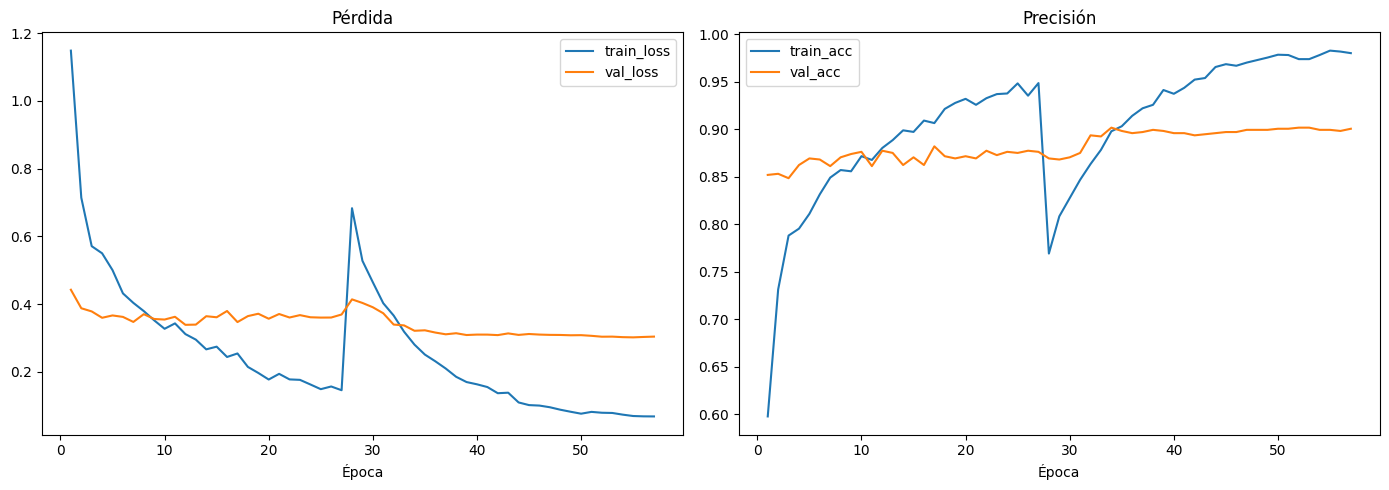


=== EVALUACIÓN TEST SET ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.8713 - loss: 0.4618
Test accuracy: 0.8713


In [3]:

# ============ GRÁFICAS ============
# Combinar historiales
for key in history1.history.keys():
    history1.history[key].extend(history2.history[key])

hist = history1.history
epochs = range(1, len(hist['loss'])+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, hist['loss'], label='train_loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.title('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist['accuracy'], label='train_acc')
plt.plot(epochs, hist['val_accuracy'], label='val_acc')
plt.title('Precisión')
plt.xlabel('Época')
plt.legend()
plt.tight_layout()
plt.show()

# ============ EVALUACIÓN ============
print("\n=== EVALUACIÓN TEST SET ===")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")




=== CLASSIFICATION REPORT ===
                precision    recall  f1-score   support

diente_de_leon       0.89      0.85      0.87       106
       girasol       0.86      0.88      0.87        74
     margarita       0.77      0.86      0.81        77
          rosa       0.86      0.89      0.88        79
       tulipan       0.97      0.89      0.93        99

      accuracy                           0.87       435
     macro avg       0.87      0.87      0.87       435
  weighted avg       0.88      0.87      0.87       435



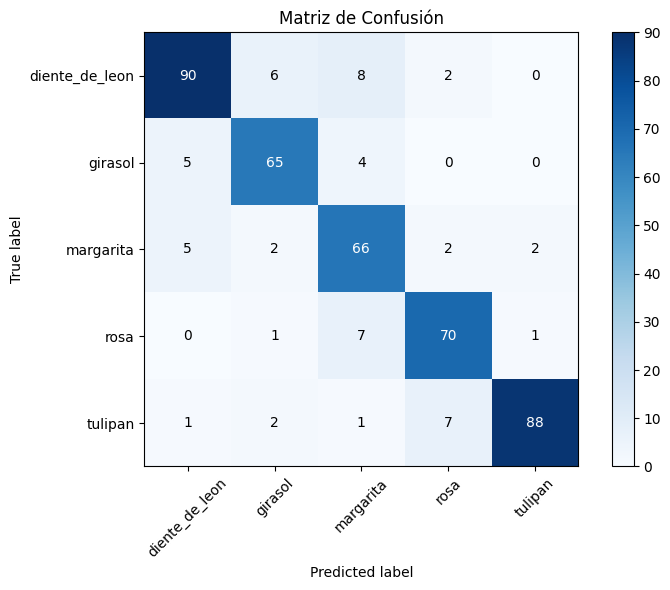

In [4]:

# ============ MATRIZ DE CONFUSIÓN ============
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()


=== CARGANDO MODELO ===



=== PREDICCIÓN ===


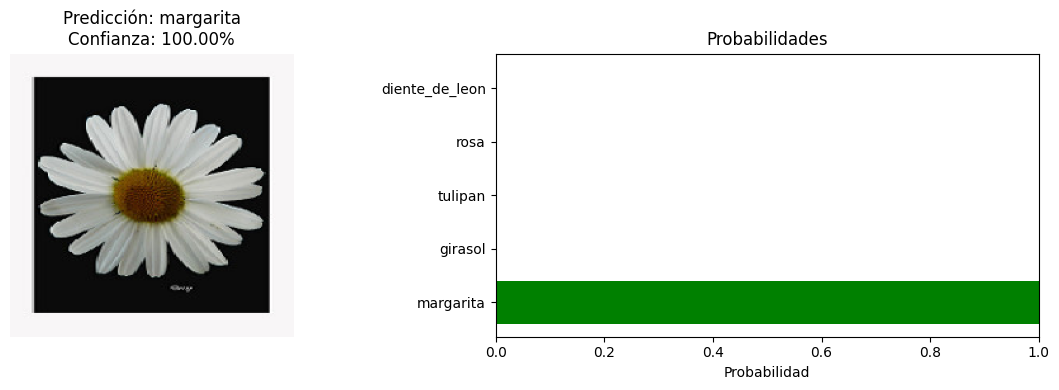


Clase predicha: margarita
Confianza: 100.00%

Todas las probabilidades:
  diente_de_leon: 0.00%
  girasol: 0.00%
  margarita: 100.00%
  rosa: 0.00%
  tulipan: 0.00%


In [7]:

# ============ FUNCIÓN DE PREDICCIÓN ============
def predict_image(model, img_path, class_names, image_size=(224,224)):
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    preds = model.predict(x, verbose=0)[0]
    top_idx = np.argmax(preds)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicción: {class_names[top_idx]}\nConfianza: {preds[top_idx]:.2%}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    sorted_idx = np.argsort(preds)[::-1]
    colors = ['green' if i == top_idx else 'skyblue' for i in sorted_idx]
    plt.barh([class_names[i] for i in sorted_idx], [preds[i] for i in sorted_idx], color=colors)
    plt.xlabel('Probabilidad')
    plt.title('Probabilidades')
    plt.xlim([0, 1])
    plt.tight_layout()
    plt.show()
    
    return top_idx, preds[top_idx], preds

# ============ CARGAR Y PROBAR ============
print("\n=== CARGANDO MODELO ===")
inference_model = tf.keras.models.load_model("flower_model_final.h5")

print("\n=== PREDICCIÓN ===")
idx, prob, all_probs = predict_image(inference_model, "3625257860_33efeef614_m.jpg", class_names)

print(f"\nClase predicha: {class_names[idx]}")
print(f"Confianza: {prob:.2%}")
print("\nTodas las probabilidades:")
for cls, p in zip(class_names, all_probs):
    print(f"  {cls}: {p:.2%}")